In [ ]:
## This is a series of examples demonstrating the use of the icanswim/qchem repo 
## for quantum mechanic geometric machine learning utilizing pytorch, pyg and rdkit.
## This is a demonstration of the use of the icanswim/cosmosis repo for 
## data science and machine learning projects.

In [13]:
import sys # required for relative imports in jupyter lab
sys.path.insert(0, '../')

import warnings
warnings.filterwarnings('ignore', category=UserWarning,
                            message='TypedStorage is deprecated')

import copy
import numpy as np

from cosmosis.model import FFNet
from cosmosis.dataset import SKDS, Pad1d, FlattenN, Reshape, ExpandN
from cosmosis.dataset import SqueezeN, Index, EmbedLookup, AsSparse, AsTensor

from learning import Learn, Selector
from dataset import QM7, QM7b, QM7X, ANI1x, QM9, PGDS
from model import GraphNet, PygModel, EncoderLoss, GraphNetVariationalEncoder 

from torch.optim import Adam
from torch.nn import MSELoss, L1Loss, NLLLoss, CrossEntropyLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T


loading QM9 datadic from a pickled copy...
CDataset created...
QDataset created...
Data(x=[11, 3], edge_index=[2, 20], edge_attr=[20, 4], y=[1], idx=13, coulomb=[11, 11], distance=[11, 11], adjacency=[11, 11], mulliken=[11, 1], embed1=[29], embed2=[29])


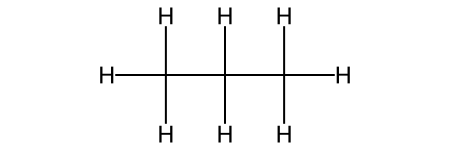

In [2]:
# qchem dataset (QM9) with PyG Data output
# extract, filter, save, transform, display

qm9_features = ['A','B','C','mu','alpha','homo','lumo', 'gap','r2','zpve',
                'U0','U','H','G','Cv','qm9_n_atoms','qm9_block','qm9_atom_type',
                'qm9_xyz','mulliken','in_file','smile','distance','coulomb']

rdkit_features = ['atom_type','atomic_number','aromatic','chirality',
                  'degree','charge','n_hs','n_rads','hybridization',
                  'edge_indices','edge_attr','rdmol_block','n_atoms',
                  'xyz','distance','coulomb','adjacency','rdmol']

rdkit_edge = ['edge_indices','edge_attr']

lookup_hybrid = QM9.embed_lookup['hybridization']
lookup_chiral = QM9.embed_lookup['chirality']

ds_param = {'train_param': {'input_dict': {'x': [
                                                 'atomic_number',
                                                 'aromatic',
                                                 'degree',
                                                  ],
                                            'idx': ['idx'],
                                            'edge_index': ['edge_indices'],
                                            'edge_attr': ['edge_attr'],
                                            'coulomb': ['coulomb'],
                                            'distance': ['distance'],
                                            'adjacency': ['adjacency'],
                                            'mulliken': ['mulliken'],
                                            'embed1': ['hybridization'],
                                            'embed2': ['chirality'],
                                            'y': ['U0']},
                              'transforms': {
                                             'hybridization': [Pad1d(29), EmbedLookup(lookup_hybrid), AsTensor()],
                                             'chirality': [Pad1d(29), EmbedLookup(lookup_chiral), AsTensor()],
                                             'atomic_number': [ExpandN(1),AsTensor()],
                                             'aromatic': [ExpandN(1), AsTensor()],
                                             'degree': [ExpandN(1), AsTensor()],
                                             'edge_indices': [AsTensor()],
                                             'mulliken': [ExpandN(1), AsTensor()],
                                             'coulomb': [AsTensor()],
                                             'distance': [],
                                             'adjacency': [],
                                             'idx': [AsTensor()],
                                             'U0': [AsTensor()],
                                            },
                              'filter_on': ('n_atoms','>','8'), 
                              'n': 100, #non-random subset for testing,
                              'use_pickle': 'test.pkl', #use pickle if exists otherwise create
                              'n_conformers': 0,
                              'dict2data': True}}

qm9 = QM9(**ds_param['train_param'])
k = qm9.ds_idx[0]
print(qm9[k])
qm9.ds[k].rdmol

In [8]:
# exploring qchem dataset (QM9) 

l, s, li, si = 0, 9999, 0, 0
for i in qm9.ds_idx:
    d = qm9[i]['mulliken'].shape[0]
    if d > l:
        l = d
        li = i
    if d < s:
        s = d
        si = i
print('longest molecule index: ', li, ' length: ', l)
print('shortest molecule index: ', si, ' length: ', s)
qm9[si]


longest molecule index:  54  length:  17
shortest molecule index:  14  length:  9


Data(x=[9, 3], edge_index=[2, 16], edge_attr=[16, 4], y=[1], idx=14, coulomb=[9, 9], distance=[9, 9], adjacency=[9, 9], mulliken=[9, 1], embed1=[29], embed2=[29])

shortest molecule


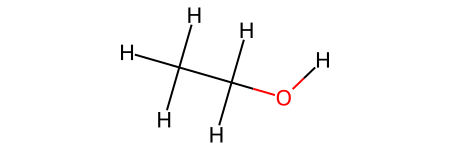

In [9]:
# display qchem dataset (QM9)

print('shortest molecule')
qm9.ds[si].rdmol

longest molecule


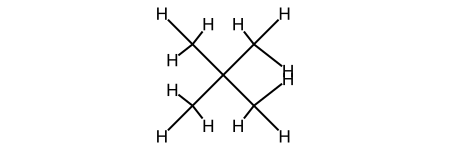

In [10]:
# display qchem dataset (QM9)

print('longest molecule')
qm9.ds[li].rdmol

In [14]:
# qchem dataset (QM9) batch and loader mechanism with pyG Data output
# augmented with rdkit mol data (2.7 GB, 133,885 molecules)
# the preprocessing can be greedy or thrifty to optimize speed or memory
# extract, filter, save, transform, load, display

qm9_features = ['A','B','C','mu','alpha','homo','lumo', 'gap','r2','zpve',
                'U0','U','H','G','Cv','qm9_n_atoms','qm9_block','qm9_atom_type',
                'qm9_xyz','mulliken','in_file','smile','distance','coulomb']

rdkit_features = ['atom_type','atomic_number','aromatic','chirality',
                  'degree','charge','n_hs','n_rads','hybridization',
                  'edge_indices','edge_attr','rdmol_block','n_atoms',
                  'xyz','distance','coulomb','adjacency','rdmol']

rdkit_edge = ['edge_indices','edge_attr']

lookup_hybrid = QM9.embed_lookup['hybridization']
lookup_chiral = QM9.embed_lookup['chirality']
                                          
ds_param = {'train_param': {'input_dict': {'x': [
                                                 'atomic_number',
                                                 'aromatic',
                                                 'degree',
                                                  ],
                                             'idx': ['idx'],
                                             'edge_index': ['edge_indices'],
                                             #'edge_attr': ['edge_attr'],
                                             #'coulomb': ['coulomb'],
                                             #'distance': ['distance'],
                                             #'adjacency': ['adjacency'],
                                             #'mulliken': ['mulliken'],
                                             'hybridization': ['hybridization'],
                                             'chirality': ['chirality'],
                                             'y': ['U0']},
                              'transforms': {
                                             'hybridization': [Pad1d(29), EmbedLookup(lookup_hybrid), AsTensor()],
                                             'chirality': [Pad1d(29), EmbedLookup(lookup_chiral), AsTensor()],
                                             'atomic_number': [ExpandN(1), AsTensor()],
                                             'aromatic': [ExpandN(1), AsTensor()],
                                             'degree': [ExpandN(1), AsTensor()],
                                             'edge_indices': [AsTensor()],
                                             'mulliken': [Pad1d(29), AsTensor()],
                                             'coulomb': [FlattenN(), Pad1d(29*29), AsTensor()],
                                             'distance': [],
                                             'adjacency': [],
                                             'idx': [AsTensor()],
                                             'U0': [AsTensor()],
                                            },
                              #'filter_on': ('n_atoms','<','10'), 
                              'n': 1000, #non-random subset for testing,
                              #'use_pickle': 'full_ds_3_confs', #use pickle if exists otherwise create
                              'n_conformers': 3,
                              'dict2data': True}}

qm9 = QM9(**ds_param['train_param'])

ds_idx = qm9.ds_idx
selector = Selector(train_idx=ds_idx)
selector('train')
loader = DataLoader(qm9, batch_size=2, sampler=selector)
batch = next(iter(loader))
print('batch: ', batch)
print('batch.ptr: ', batch.ptr)
print('batch.idx: ', batch.idx)
print('batch.x: ', batch.x)
print('pgds[1]: ', qm9[1])
print('pgds[1].x: ', qm9[1].x)
print('pgds[1].y: ', qm9[1].y)
print('pgds[1].idx: ', qm9[1].idx)
print('pgds[1].edge_index: ', qm9[1].edge_index)
print('pgds[1].edge_attr: ', qm9[1].edge_attr)

creating QM9 dataset...
molecules scanned:  1
molecules created:  1
total molecules scanned:  1000
total uncharacterized molecules removed:  25
total molecules removed for insuffient rdmol conformations:  0
total molecules created:  975
CDataset created...
QDataset created...
batch:  DataBatch(x=[30, 3], edge_index=[2, 60], y=[2], idx=[2], hybridization=[58], chirality=[58], batch=[30], ptr=[3])
batch.ptr:  tensor([ 0, 14, 30])
batch.idx:  tensor([521, 651])
batch.x:  tensor([[6., 0., 4.],
        [6., 0., 2.],
        [6., 0., 2.],
        [6., 0., 4.],
        [6., 0., 4.],
        [8., 0., 2.],
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        [6., 0., 4.],
        [6., 0., 4.],
        [6., 0., 4.],
        [6., 0., 4.],
        [6., 0., 4.],
        [6., 0., 4.],
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],

In [12]:
# PyG QM9 dataset wrapper PGDS

ds_param = {'train_param': {'dataset': 'QM9',
                            'transforms': {},
                            'pg_param': {'root': './data/',
                                         'transform': None}}}

pgds = PGDS(**ds_param['train_param'])
print(pgds[0])

creating pytorch geometric QM9 dataset...
CDataset created...
Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], z=[5], smiles='[H]C([H])([H])[H]', name='gdb_1', idx=[1])


In [8]:
# PyG dataset wrapper (PGDS) batch and loader mechanism
# extract, transform, load, display

import copy
class IndexY(T.BaseTransform):
    def __init__(self, i):
        self.i = i
        
    def __call__(self, data):
        # Shallow-copy the data so that we prevent in-place data modification.
        return self.forward(copy.copy(data))
    
    def forward(self, data):
        y = data.y[:,self.i]
        data.y = y
        return data

ds_param = {'train_param': {'dataset': 'QM9',
                              'pg_param': {'root': './data/',
                                            'transform': IndexY(7)}}}

pgds = PGDS(**ds_param['train_param'])
ds_idx = pgds.ds_idx
selector = Selector(train_idx=ds_idx)
selector('train')
loader = DataLoader(pgds, batch_size=2, sampler=selector)
batch = next(iter(loader))
print('batch: ', batch)
print('batch.ptr: ', batch.ptr)
print('batch.idx: ', batch.idx)
print('batch.x: ', batch.x)
print('pgds[1]: ', pgds[1])
print('pgds[1].x: ', pgds[1].x)
print('pgds[1].y: ', pgds[1].y)
print('pgds[1].idx: ', pgds[1].idx)
print('pgds[1].edge_index: ', pgds[1].edge_index)
print('pgds[1].edge_attr: ', pgds[1].edge_attr)

creating pytorch geometric QM9 dataset...
CDataset created...
batch:  DataBatch(x=[40, 11], edge_index=[2, 84], edge_attr=[84, 4], y=[2], pos=[40, 3], z=[40], smiles=[2], name=[2], idx=[2], batch=[40], ptr=[3])
batch.ptr:  tensor([ 0, 22, 40])
batch.idx:  tensor([88544, 11220])
batch.x:  tensor([[0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 3.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 2.],
        [0., 0., 1., 0., 0., 7., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 2.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 2.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 2.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [

creating QM9 dataset...
molecules scanned:  1
molecules created:  0
molecules scanned:  10001
molecules created:  9901
molecules scanned:  20001
molecules created:  19900
molecules scanned:  30001
molecules created:  29887
molecules scanned:  40001
molecules created:  39887
molecules scanned:  50001
molecules created:  49887
molecules scanned:  60001
molecules created:  59887
molecules scanned:  70001
molecules created:  69887
molecules scanned:  80001
molecules created:  79887
molecules scanned:  90001
molecules created:  89887
molecules scanned:  100001
molecules created:  99887
molecules scanned:  110001
molecules created:  109887
molecules scanned:  120001
molecules created:  119887
molecules scanned:  130001
molecules created:  129887
total molecules scanned:  133885
total uncharacterized molecules removed:  3048
total molecules removed for insuffient rdmol conformations:  0
total molecules created:  130723
CDataset created...
QDataset created...
FFNet model loaded...
CModel loade

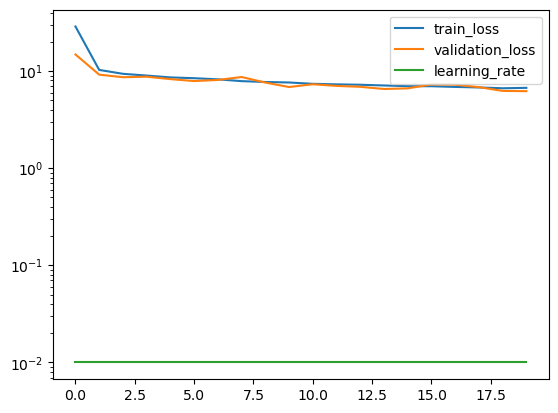

In [2]:
# qchem dataset (QM9) with comosis model (FFNet)
# extract, filter, transform, embed, save, load, model, metrics, display


qm9_features = ['A','B','C','mu','alpha','homo','lumo', 'gap','r2','zpve',
                'U0','U','H','G','Cv','qm9_n_atoms','qm9_block','qm9_atom_type',
                'qm9_xyz','mulliken','in_file','smile','distance','coulomb']

rdkit_features = ['atom_type','atomic_number','aromatic','chirality',
                  'degree','charge','n_hs','n_rads','hybridization',
                  'edge_indices','edge_attr','rdmol_block','n_atoms',
                  'xyz','distance','coulomb','adjacency','rdmol']

rdkit_edge = ['edge_indices','edge_attr']

lookup_hybrid = QM9.embed_lookup['hybridization']
lookup_chiral = QM9.embed_lookup['chirality']
# cosmosis uses 'X' and 'y' while 'pyg' uses 'x' and 'y'

ds_param = {'train_param': {'input_dict': {'X': [
                                                 'atomic_number',
                                                 'aromatic',
                                                 'degree',
                                                 'mulliken',
                                                 'coulomb',
                                                  ],
                                             #'idx': ['idx'],
                                             #'edge_index': ['edge_indices'],
                                             #'edge_attr': ['edge_attr'],
                                             #'coulomb': ['coulomb'],
                                             #'distance': ['distance'],
                                             #'adjacency': ['adjacency'],
                                             #'mulliken': ['mulliken'],
                                             'hybridization': ['hybridization'],
                                             'chirality': ['chirality'],
                                             'y': ['U0']},
                              'transforms': {
                                             'hybridization': [Pad1d(29), EmbedLookup(lookup_hybrid), AsTensor()],
                                             'chirality': [Pad1d(29), EmbedLookup(lookup_chiral), AsTensor()],
                                             'atomic_number': [Pad1d(29), AsTensor()],
                                             'aromatic': [Pad1d(29), AsTensor()],
                                             'degree': [Pad1d(29), AsTensor()],
                                             'edge_indices': [AsTensor()],
                                             'mulliken': [Pad1d(29), AsTensor()],
                                             'coulomb': [FlattenN(), Pad1d(29*29), AsTensor()],
                                             'distance': [],
                                             'adjacency': [],
                                             'idx': [AsTensor()],
                                             'U0': [AsTensor()],
                                            },
                              'filter_on': ('n_atoms','>','8'), 
                              #'n': 1000, #non-random subset for testing,
                              'use_pickle': 'n_atoms_greater_than_8_3_conf', #use pickle if exists otherwise create
                              'n_conformers': 3,
                              'dict2data': False}}

model_param = {'in_channels': 29+29+29+29+29*29+8*29+8*29,
               'hidden': 2048, 
               'out_channels': 1, 
               'model_name': 'funnel',
               'embed_param': {'hybridization': (9,8,0,True),
                               'chirality': (4,8,0,True),
                               'flatten': True}}

metrics_param = {'report_interval': 100,
                 'log_plot': True,
                 'min_lr': .0013} #early stopping when lr is =<

crit_param = {'reduction': 'sum'}

sample_param = {'set_seed': 88,
                 'splits': (.7,.15),
                 #'subset': .1, #create random subset
                }

sched_param = {'factor': .6,
                'patience': 5,
                'cooldown': 5,
                'min_lr': .00125} #plateau at this value

opt_param = {'lr': 0.01}


l = Learn([QM9], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss,
          model_param=model_param, ds_param=ds_param, sample_param=sample_param,
          opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
          metrics_param=metrics_param,
          squeeze_y_pred=False, batch_size=128, epochs=20, save_model=False)

creating pytorch geometric QM9 dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
GraphNet <module 'torch_geometric.nn.conv' from '/home/fltr/anaconda3/envs/qchem/lib/python3.12/site-packages/torch_geometric/nn/conv/__init__.py'> loaded...
CModel loaded...
running model on gpu...

...........................
learning time: 0:00:52.207491
epoch: 0, lr: 0.01
train loss: 110271065.63585435, val loss: 79339239.15789473
last 5 targets: 
[-10427.34  -11914.588 -10440.464 -12418.075 -10847.889]
last 5 predictions: 
[-2041.0955 -1907.5994 -1696.0142 -2549.7788 -2874.073 ]

...........................
learning time: 0:03:13.977193
epoch: 3, lr: 0.01
train loss: 1780405.9754901961, val loss: 1661890.9917763157
last 5 targets: 
[-10473.517 -11440.859 -11508.856 -11511.891 -11946.602]
last 5 predictions: 
[-12126.566 -11412.811 -11727.451 -11467.465 -12125.794]

...........................
learning time: 0:05:34.465312
epoch: 6, lr: 0.01
train loss: 1562271.4964985994, val loss:

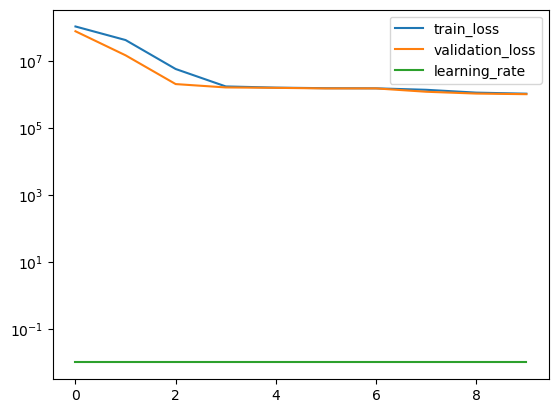

In [2]:
# qchem PyG dataset wrapper (PGDS) with qchem model (GraphNet)
# NetConv convolutions with edge features
# extract, transform, load, model, metrics, display

class IndexY(T.BaseTransform):
    def __init__(self, i):
        self.i = i
        
    def __call__(self, data):
        # Shallow-copy the data so that we prevent in-place data modification.
        return self.forward(copy.copy(data))
    
    def forward(self, data):
        y = data.y[:,self.i]
        data.y = y
        return data

model_param = {'in_channels': 11, 
               'hidden': 128, 
               'out_channels': 1,
               'depth': 2,
               'convolution': 'NetConv', # uses edge features
               'pool': 'MeanAggregation',
               'dropout': .1,
               'softmax': None,
               'activation': 'relu',
               'edge_features': 4,
               }

ds_param = {'train_param': {'dataset': 'QM9',
                            'transforms': {},
                            'pg_param': {'root': './data/',
                                         'transform': T.Compose([IndexY(7)])}}}

metrics_param = {'report_interval': 100,
                 'log_plot': True,
                 'min_lr': .0013}

opt_param = {'lr': 0.01}

crit_param = {'reduction': 'sum'}

sample_param = {'set_seed': 88,
                'splits': (.7, .15)}

sched_param = {'factor': .6,
               'patience': 5,
               'cooldown': 5,
               'min_lr': .00125}


l = Learn([PGDS], GraphNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, DataLoader=DataLoader,
          model_param=model_param, ds_param=ds_param, sample_param=sample_param,
          opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
          metrics_param=metrics_param,
          squeeze_y_pred=True, batch_size=256, epochs=2)

# cosmosis qm9 feature U0 is in hartree while pyg qm9 U0 (y[7]) is in eV 
# hartree * 27.2114 = eV

creating pytorch geometric QM9 dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
GraphNet <module 'torch_geometric.nn.conv' from '/home/fltr/anaconda3/envs/qchem/lib/python3.12/site-packages/torch_geometric/nn/conv/__init__.py'> loaded...
CModel loaded...
running model on gpu...

...........................
learning time: 0:00:28.734012
epoch: 0, lr: 0.01
train loss: 97407964.26890756, val loss: 48498987.0
last 5 targets: 
[-10427.34  -11914.588 -10440.464 -12418.075 -10847.889]
last 5 predictions: 
[-4548.989 -5445.637 -5466.282 -5979.433 -5356.248]

...........................
learning time: 0:02:15.696349
epoch: 9, lr: 0.01
train loss: 757063.6102941176, val loss: 733080.3116776316
last 5 targets: 
[-11477.058 -11946.661 -10534.066 -10396.539 -11545.203]
last 5 predictions: 
[-10927.802 -11157.962  -9570.621 -10371.242 -10855.747]
test loss: 753918.7405427631

...........................
learning time: 0:02:21.403173
last 5 targets: 
[ -9554.702 -11948.14  -12385

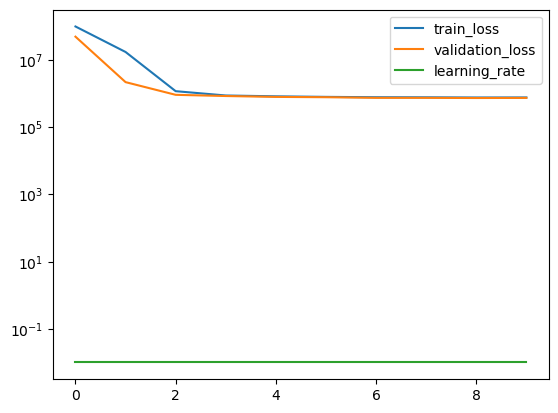

In [3]:
# qchem PyG dataset wrapper (PGDS) with qchem model (GraphNet)
# SAGEConv convolutions
# extract, transform, load, model, metrics, display

class IndexY(T.BaseTransform):
    def __init__(self, i):
        self.i = i
        
    def __call__(self, data):
        # Shallow-copy the data so that we prevent in-place data modification.
        return self.forward(copy.copy(data))
    
    def forward(self, data):
        y = data.y[:,self.i]
        data.y = y
        return data

model_param = {'in_channels': 11, 
                'hidden': 256, 
                'out_channels': 1,
                'depth': 2,
                'convolution': 'SAGEConv',
                'pool': 'MeanAggregation',
                'dropout': .1,
                'softmax': None,
                'activation': 'relu'}

ds_param = {'train_param': {'dataset': 'QM9',
                              'transforms': {},
                              'pg_param': {'root': './data/',
                                           'transform': T.Compose([IndexY(7)])}}}

metrics_param = {'report_interval': 100,
                 'log_plot': True,
                 'min_lr': .0013}

opt_param = {'lr': 0.01}

crit_param = {'reduction': 'sum'}

sample_param = {'set_seed': 88,
                 'splits': (.7, .15)}

sched_param = {'factor': .6,
               'patience': 5,
               'cooldown': 5,
               'min_lr': .00125}


l = Learn([PGDS], GraphNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, DataLoader=DataLoader,
          model_param=model_param, ds_param=ds_param, sample_param=sample_param,
          opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
          metrics_param=metrics_param,
          squeeze_y_pred=True, batch_size=256, epochs=10)

loading QM9 datadic from a pickled copy...
CDataset created...
QDataset created...
FFNet model loaded...
CModel loaded...
GraphNet <module 'torch_geometric.nn.conv' from '/home/fltr/anaconda3/envs/qchem/lib/python3.12/site-packages/torch_geometric/nn/conv/__init__.py'> loaded...
CModel loaded...
running model on gpu...

...........................
learning time: 0:00:13.599536
epoch: 0, lr: 0.01
train loss: 33567.24302831484, val loss: 1572.765530234889
last 5 targets: 
[-417.99368 -422.97815 -456.37347 -399.29926 -476.2618 ]
last 5 predictions: 
[-426.80713 -444.7693  -443.71918 -425.24823 -421.82874]

...........................
learning time: 0:02:02.900226
epoch: 9, lr: 0.01
train loss: 977.6284865264465, val loss: 1001.3254547119141
last 5 targets: 
[-401.94836 -455.20895 -460.13004 -458.98535 -403.08136]
last 5 predictions: 
[-420.62787 -462.8322  -432.95587 -410.8565  -371.85995]
test loss: 999.7506770083779

...........................
learning time: 0:02:04.713971
last 5 targe

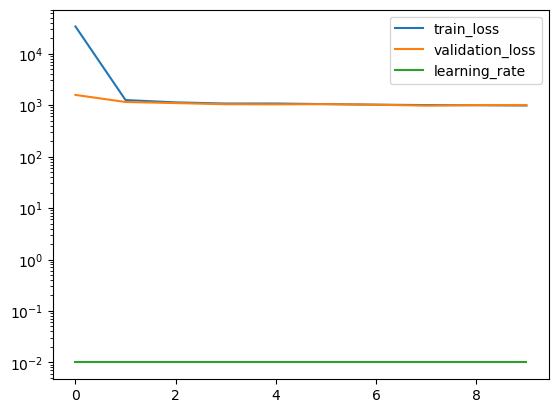

In [2]:
# qchem dataset (QM9) with qchem model (GraphNet)
# extract, filter, transform, embed, save, load, model, metrics, display

qm9_features = ['A','B','C','mu','alpha','homo','lumo', 'gap','r2','zpve',
                'U0','U','H','G','Cv','qm9_n_atoms','qm9_block','qm9_atom_type',
                'qm9_xyz','mulliken','in_file','smile','distance','coulomb']

rdkit_features = ['atom_type','atomic_number','aromatic','chirality',
                  'degree','charge','n_hs','n_rads','hybridization',
                  'edge_indices','edge_attr','rdmol_block','n_atoms',
                  'xyz','distance','coulomb','adjacency','rdmol']

rdkit_edge = ['edge_indices','edge_attr']

lookup_hybrid = QM9.embed_lookup['hybridization']
lookup_chiral = QM9.embed_lookup['chirality']

ds_param = {'train_param': {'input_dict': {'x': [
                                                 'atomic_number',
                                                 'aromatic',
                                                 'degree',
                                                  ],
                                             'idx': ['idx'],
                                             'edge_index': ['edge_indices'],
                                             #'edge_attr': ['edge_attr'],
                                             #'coulomb': ['coulomb'],
                                             #'distance': ['distance'],
                                             #'adjacency': ['adjacency'],
                                             #'mulliken': ['mulliken'],
                                             #'hybridization': ['hybridization'],
                                             #'chirality': ['chirality'],
                                             'y': ['U0']},
                              'transforms': {
                                             'hybridization': [Pad1d(29), EmbedLookup(lookup_hybrid), AsTensor()],
                                             'chirality': [Pad1d(29), EmbedLookup(lookup_chiral), AsTensor()],
                                             'atomic_number': [ExpandN(1), AsTensor()],
                                             'aromatic': [ExpandN(1), AsTensor()],
                                             'degree': [ExpandN(1), AsTensor()],
                                             'edge_indices': [AsTensor()],
                                             'mulliken': [Pad1d(29), AsTensor()],
                                             'coulomb': [FlattenN(), Pad1d(29*29), AsTensor()],
                                             'distance': [],
                                             'adjacency': [],
                                             'idx': [AsTensor()],
                                             'U0': [AsTensor()],
                                            },
                              'filter_on': ('n_atoms','>','8'), 
                              #'n': 10000, #non-random subset for testing,
                              'use_pickle': 'n_atoms_greater_than_8_3_conf',
                              'n_conformers': 3,
                              'dict2data': True}}

model_param = {'in_channels': 3, 
                'hidden': 256, 
                'out_channels': 1,
                'depth': 2,
                'convolution': 'SAGEConv',
                'pool': 'MeanAggregation',
                'dropout': .1,
                'softmax': None,
                'activation': 'relu',
               }

metrics_param = {'report_interval': 100,
                  'log_plot': True,
                  'min_lr': .0013}  #early stopping

opt_param = {'lr': 0.01}

crit_param = {'reduction': 'sum'}

sample_param = {'set_seed': 88,
                 'splits': (.7, .15)}

sched_param = {'factor': .6,
                'patience': 10,
                'cooldown': 5,
                'min_lr': .00125}


l = Learn([QM9], GraphNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, DataLoader=DataLoader,
          model_param=model_param, ds_param=ds_param, sample_param=sample_param,
          opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
          metrics_param=metrics_param,
          squeeze_y_pred=True, batch_size=256, epochs=10, save_model=True, 
          load_model=None)

creating pytorch geometric QM9 dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
GraphNet <module 'torch_geometric.nn.conv' from '/home/fltr/anaconda3/envs/qchem/lib/python3.12/site-packages/torch_geometric/nn/conv/__init__.py'> loaded...
CModel loaded...
FFNet model loaded...
CModel loaded...
FFNet model loaded...
CModel loaded...
GraphNetVariationalEncoder loaded...
CModel loaded...
running model on gpu...

...........................
learning time: 0:01:43.832259
epoch: 0, lr: 0.01
train loss: 0.01084393787008899, val loss: 0.02716953212431833
last 5 targets: 
[0. 0. 0. 0. 0.]
last 5 predictions: 
[0.8253945 0.9998274 0.7373816 0.6094021 0.9050587]
sklearn train metric: 0.6647565027257025, sklearn validation metric: 0.7374961612023698

...........................
learning time: 0:03:08.887986
epoch: 1, lr: 0.01
train loss: 0.009803429103970944, val loss: 0.02513782760384036
last 5 targets: 
[0. 0. 0. 0. 0.]
last 5 predictions: 
[0.84484696 0.73988944 0.64680797 0

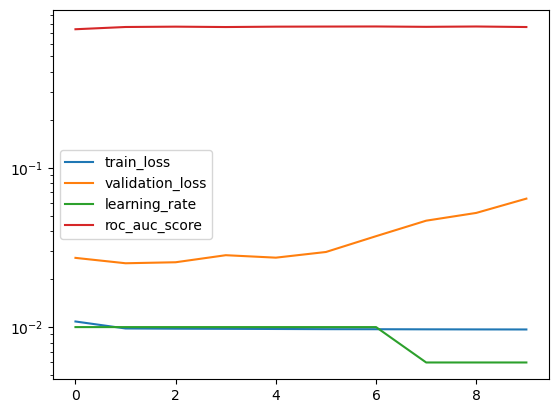

In [4]:
# qchem PyG dataset wrapper (PGDS) with qchem model (GraphNetVariationalEncoder)
# graph variational autoencoder WITHOUT adversarial regulation and GCNConv encoder
# extract, load, model, metrics, display

model_param = {'in_channels': 11, 
               'hidden': 32, 
               'out_channels': 32,
               'depth': 2,
               'softmax': None,
               'pool': None,
               'convolution': 'GCNConv'}

ds_param = {'train_param': {'dataset': 'QM9',
                            'transforms': {},
                            'pg_param': {'root': './data/',
                                         'transform': None}}}

metrics_param = {'report_interval': 10,
                 'log_plot': True,
                 'min_lr': .0013,
                 'sk_metric_name': 'roc_auc_score',
                 'sk_param': {'average': 'macro',
                              'multi_class': 'ovr'}}

opt_param = {'lr': 0.01}

crit_param = {'adversarial': False,
              'disc_param': {'in_channels': 32, 'hidden': 64, 
                             'out_channels': 32, 'softmax': None}}

sample_param = {'set_seed': 88,
                'splits': (.7, .15),
                'subset': False}

sched_param = {'factor': .6,
               'patience': 5,
               'cooldown': 5,
               'min_lr': .00125}


l = Learn([PGDS], GraphNetVariationalEncoder, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=EncoderLoss, DataLoader=DataLoader,
          model_param=model_param, ds_param=ds_param, sample_param=sample_param,
          opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
          metrics_param=metrics_param,
          squeeze_y_pred=False, batch_size=128, epochs=10)

creating pytorch geometric QM9 dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
GraphNet <module 'torch_geometric.nn.conv' from '/home/fltr/anaconda3/envs/qchem/lib/python3.12/site-packages/torch_geometric/nn/conv/__init__.py'> loaded...
CModel loaded...
FFNet model loaded...
CModel loaded...
FFNet model loaded...
CModel loaded...
GraphNetVariationalEncoder loaded...
CModel loaded...
running model on gpu...
FFNet model loaded...
CModel loaded...

...........................
learning time: 0:01:51.108454
epoch: 0, lr: 0.01
train loss: 0.01841841690711208, val loss: 0.03323347111737806
last 5 targets: 
[0. 0. 0. 0. 0.]
last 5 predictions: 
[0.09729395 0.53809905 0.8087388  0.00404584 0.4050554 ]
sklearn train metric: 0.6275825020773934, sklearn validation metric: 0.6241431347075134

...........................
learning time: 0:03:31.794431
epoch: 1, lr: 0.01
train loss: 0.015238017139474412, val loss: 0.03250533560278759
last 5 targets: 
[0. 0. 0. 0. 0.]
last 5 predi

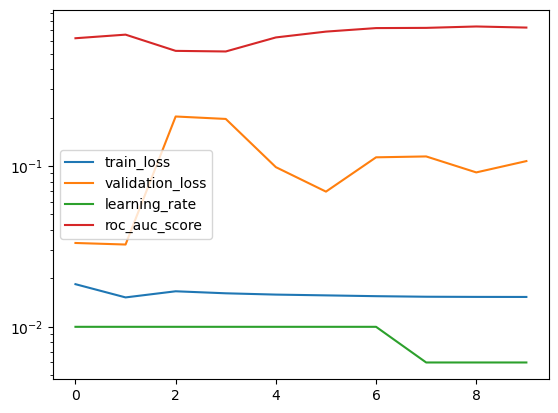

In [3]:
# qchem PyG dataset wrapper (PGDS) with qchem model (GraphNetVariationalEncoder)
# graph variational autoencoder WITH adversarial regulation and GCNConv encoder
# extract, load, model, metrics, display

model_param = {'in_channels': 11, 
               'hidden': 32, 
               'out_channels': 32,
               'depth': 2,
               'softmax': None,
               'pool': None,
               'convolution': 'GCNConv'}

ds_param = {'train_param': {'dataset': 'QM9',
                            'transforms': {},
                            'pg_param': {'root': './data/',
                                         'transform': None}}}

metrics_param = {'report_interval': 100,
                 'log_plot': True,
                 'min_lr': .0013,
                 'sk_metric_name': 'roc_auc_score',
                 'sk_param': {'average': 'macro',
                              'multi_class': 'ovr'}}

opt_param = {'lr': 0.01}

crit_param = {'adversarial': True,
              'disc_param': {'in_channels': 32, 'hidden': 64, 
                             'out_channels': 32, 'softmax': None}}

sample_param = {'set_seed': 88,
                'splits': (.7, .15),
                'subset': False}

sched_param = {'factor': .6,
               'patience': 5,
               'cooldown': 5,
               'min_lr': .00125}


l = Learn([PGDS], GraphNetVariationalEncoder, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=EncoderLoss, DataLoader=DataLoader,
          model_param=model_param, ds_param=ds_param, sample_param=sample_param,
          opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
          metrics_param=metrics_param,
          squeeze_y_pred=False, batch_size=128, epochs=10)

creating pytorch geometric QM9 dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
pytorch geometric model GraphSAGE loaded...
running model on gpu...

...........................
learning time: 0:00:29.542055
epoch: 0, lr: 0.01
train loss: 97113752.95238096, val loss: 47395068.2631579
last 5 targets: 
[-10427.34  -11914.588 -10440.464 -12418.075 -10847.889]
last 5 predictions: 
[-4297.003  -5272.1304 -4804.2944 -5373.8105 -4975.5522]

...........................
learning time: 0:02:14.893770
epoch: 9, lr: 0.01
train loss: 706676.4485294118, val loss: 685334.6122532894
last 5 targets: 
[-11477.058 -11946.661 -10534.066 -10396.539 -11545.203]
last 5 predictions: 
[ -9960.292 -12599.446 -10659.112  -9654.73  -10738.172]

...........................
learning time: 0:02:26.574860
epoch: 10, lr: 0.01
train loss: 668981.2303046219, val loss: 634255.0941611842
last 5 targets: 
[-12571.369 -11270.621 -10566.29  -11719.308 -12521.569]
last 5 predictions: 
[-11477.23   -10206.3

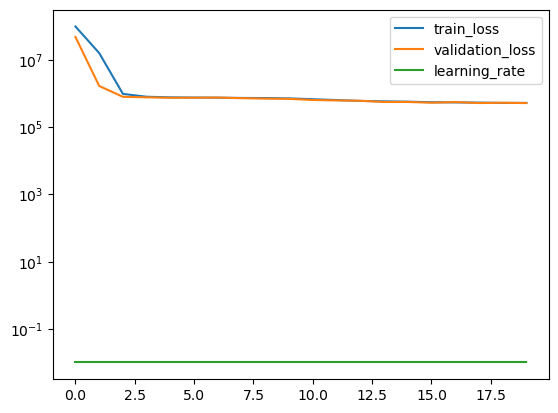

In [2]:
# qchem PyG dataset wrapper (PGDS) with qchem PyG model wrapper (PygModel)
# extract, transform, load, model, metrics, display

class IndexY(T.BaseTransform):
    def __init__(self, i):
        self.i = i
        
    def __call__(self, data):
        # Shallow-copy the data so that we prevent in-place data modification.
        return self.forward(copy.copy(data))
    
    def forward(self, data):
        y = data.y[:,self.i]
        data.y = y
        return data

model_param = {'model_name': 'GraphSAGE',
               'softmax': None,
               'pool': 'MeanAggregation',
               'ffnet': True,
               'in_channels': 256, # ffnet param
               'hidden': 256, 
               'out_channels': 1, 
               'pyg_param': {'in_channels': 11, # GraphSAGE param
                             'hidden_channels': 256,
                             'num_layers': 2,
                             'out_channels': 256,
                             'dropout': .1,
                             'norm': 'BatchNorm'}}

ds_param = {'train_param': {'dataset': 'QM9',
                            'transforms': {},
                            'pg_param': {'root': './data/',
                                         'transform': T.Compose([IndexY(7)])}}}

metrics_param = {'report_interval': 100,
                 'log_plot': True,
                 'min_lr': .0013}  #early stopping

opt_param = {'lr': 0.01}

crit_param = {'reduction': 'sum'}

sample_param = {'set_seed': 88,
                'splits': (.7, .15)}

sched_param = {'factor': .6,
               'patience': 5,
               'cooldown': 5,
               'min_lr': .00125}


l = Learn([PGDS], PygModel, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, DataLoader=DataLoader,
          model_param=model_param, ds_param=ds_param, sample_param=sample_param,
          opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
          metrics_param=metrics_param,
          squeeze_y_pred=True, batch_size=256, epochs=20)

creating pytorch geometric QM9 dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...

...........................
learning time: 0:00:41.623270
epoch: 0, lr: 0.01
train loss: 78458382.15406163, val loss: 15486607.52631579
last 5 targets: 
[-10427.34  -11914.588 -10440.464 -12418.075 -10847.889]
last 5 predictions: 
[-5227.773  -8160.319  -7405.637  -8581.778  -6828.8403]

...........................
learning time: 0:02:32.924736
epoch: 5, lr: 0.01
train loss: 192399.60587359944, val loss: 179983.75102796053
last 5 targets: 
[-14638.252 -10631.344 -10937.895 -11510.78   -9555.934]
last 5 predictions: 
[-13433.3545 -10978.653  -11066.358  -11839.801   -9983.8545]

...........................
learning time: 0:04:22.869652
epoch: 10, lr: 0.01
train loss: 177012.51538427873, val loss: 173833.64915707236
last 5 targets: 
[-12571.369 -11270.621 -10566.29  -11719.308 -12521.569]
last 5 predictions: 
[-12758.959 -11678.428 -10752.121 -11969.605 -12353.373

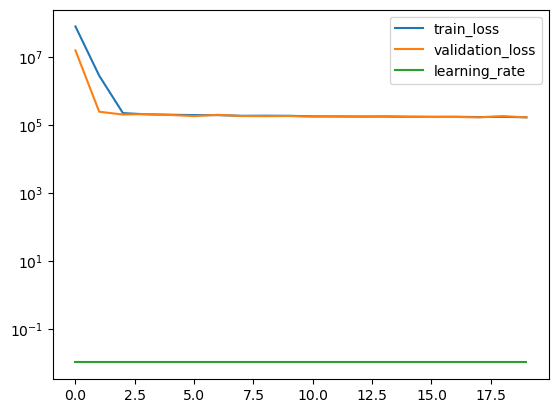

In [4]:
# qchem PyG dataset wrapper (PGDS) with cosmosis model (FFNet)
# dictionary output
# extract, transform, load, model, metrics, display

model_param = {'in_channels': 319, 
                'hidden': 512, 
                'out_channels': 1, 
                'model_name': 'funnel'}
#qchem model keys are 'X' and 'y' while pyg used 'x' and 'y'
ds_param = {'train_param': {'dataset': 'QM9',
                            'transforms': {'y': [Index(7)],
                                           'x': [FlattenN(), Pad1d(29*11)]},
                            'input_dict': {'X': ['x'], 
                                           'y': ['y']},
                            'pg_param': {'root': './data/'}}}

metrics_param = {'report_interval': 100,
                  'log_plot': True,
                  'min_lr': .0013}  #early stopping

opt_param = {'lr': 0.01}

crit_param = {'reduction': 'sum'}

sample_param = {'set_seed': 88,
                'splits': (.7, .15)}

sched_param = {'factor': .6,
               'patience': 5,
               'cooldown': 5,
               'min_lr': .00125}



l = Learn([PGDS], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, 
          model_param=model_param, ds_param=ds_param, sample_param=sample_param,
          opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
          metrics_param=metrics_param,
          batch_size=256, epochs=20)

CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...

...........................
learning time: 0:00:00.756107
epoch: 0, lr: 0.01
train loss: 1489.1889455694902, val loss: 1401.9192199707031
last 5 targets: 
[-1809.1  -1455.85 -1556.54 -1301.34 -1790.14]
last 5 predictions: 
[-141.6654  -123.34814 -136.57785 -105.44487 -132.99048]

...........................
learning time: 0:00:02.511341
epoch: 10, lr: 0.01
train loss: 44.824660652562194, val loss: 45.94597911834717
last 5 targets: 
[-1285.83 -1591.66 -1587.14 -1356.81 -1700.7 ]
last 5 predictions: 
[-1339.5698 -1629.2888 -1618.6414 -1439.4229 -1671.7673]

...........................
learning time: 0:00:04.242964
epoch: 20, lr: 0.01
train loss: 45.0964997944079, val loss: 36.252166748046875
last 5 targets: 
[-1718.83 -1227.48 -1505.95 -1628.37 -1374.26]
last 5 predictions: 
[-1692.2723 -1286.8186 -1527.9626 -1633.8787 -1401.7351]

...........................
learning time: 0:00:05.927768
epoch: 30, lr: 0

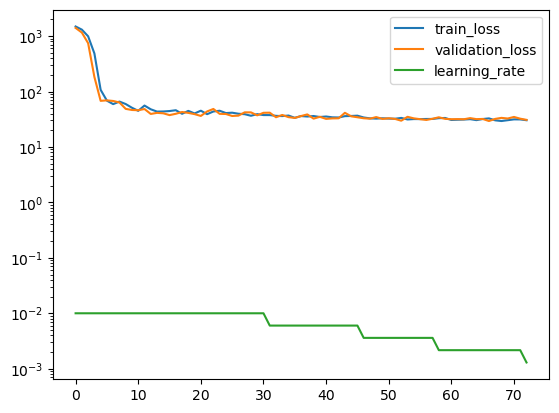

In [2]:
# qchem dataset (QM7) and cosmosis model (FFNet)
# extract, transform, load, model, metrics, display

model_param = {'in_channels': 23*23, 
               'hidden': 2048, 
               'out_channels': 1, 
               'model_name': 'funnel'}

ds_param = {'train_param': {'input_dict': {'X': ['coulomb'],
                                           'y': ['ae']},
                            'in_file': './data/qm7/qm7.mat',
                            'transforms': {'coulomb': [FlattenN()]}}}

metrics_param = {'report_interval': 100,
                  'log_plot': True,
                  'min_lr': .0013}  #early stopping

crit_param = {'reduction': 'sum'}

sample_param = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_param = {'factor': .6,
                'patience': 5,
                'cooldown': 5,
                'min_lr': .00125}


opt_param = {'lr': 0.01}

l = Learn([QM7], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_param=model_param, ds_param=ds_param, sample_param=sample_param,
          opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
          metrics_param=metrics_param,
          batch_size=256, epochs=200)

CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...

...........................
learning time: 0:00:00.287899
epoch: 0, lr: 0.01
train loss: 1515.2149593955592, val loss: 1431.9375915527344
last 5 targets: 
[-1918.446  -1878.0168 -1636.8151 -1578.769  -1432.4517]
last 5 predictions: 
[-161.34067 -147.25433 -155.94202 -127.43952 -120.78729]

...........................
learning time: 0:00:01.922052
epoch: 10, lr: 0.01
train loss: 68.95001562018143, val loss: 69.59542274475098
last 5 targets: 
[-1516.0977 -1735.5308 -1887.9491 -1618.9104 -1871.8513]
last 5 predictions: 
[-1457.3131 -1572.8724 -1806.8488 -1615.0402 -1890.35  ]

...........................
learning time: 0:00:03.543926
epoch: 20, lr: 0.01
train loss: 50.41412453902395, val loss: 60.88741970062256
last 5 targets: 
[-1475.3118 -1526.9512 -1569.5222 -1275.571  -1624.2003]
last 5 predictions: 
[-1384.9757 -1497.2284 -1492.5524 -1300.3011 -1636.5834]

...........................
learning time: 0:

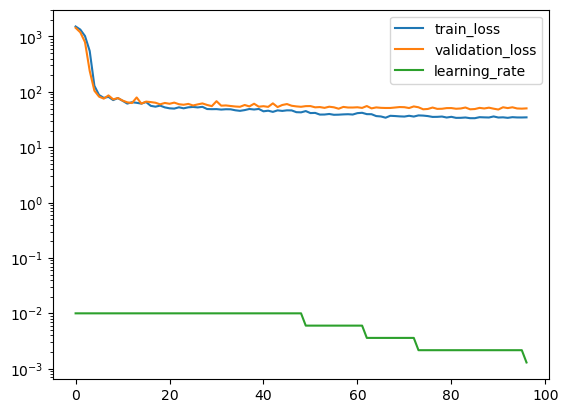

In [3]:
# qchem dataset (QM7b) and cosmosis model (FFNet)
# extract, transform, load, model, metrics, display

model_param = {'in_channels': 23*23, 
                'hidden': 2048, 
                'out_channels': 1, 
                'model_name': 'funnel'}

ds_param = {'train_param': {'input_dict': {'X': ['coulomb'],
                                           'y': ['E']},
                            'in_file': './data/qm7b/qm7b.mat',
                            'transforms': {'coulomb': [FlattenN()]}}}

metrics_param = {'report_interval': 100,
                  'log_plot': True,
                  'min_lr': .0013}  #early stopping

crit_param = {'reduction': 'sum'}

sample_param = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_param = {'factor': .6,
                'patience': 5,
                'cooldown': 5,
                'min_lr': .00125}


opt_param = {'lr': 0.01}

l = Learn([QM7b], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_param=model_param, ds_param=ds_param, sample_param=sample_param,
          opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
          metrics_param=metrics_param, 
          batch_size=256, epochs=200)

In [2]:
# exploring qchem dataset (QM7X)

features = ['DIP','HLgap','atC6','atNUM','atPOL','atXYZ','eAT','hDIP',
            'eC','eDFTB+MBD','eEE','eH','eKIN','eKSE','eL','eMBD','eNE', 
            'eNN','ePBE0','ePBE0+MBD','eTS','eX','eXC','eXX','hCHG', 
            'hRAT','hVDIP','hVOL','mC6','mPOL','mTPOL','pbe0FOR', 
            'sMIT','sRMSD','totFOR','vDIP','vEQ','vIQ','vTQ','vdwFOR','vdwR',
            'coulomb'] #(1110,) with pad=23

ds_param = {'train_param': {'input_dict': {'X': ['atNUM'],
                                           'y': ['eAT']},
                            'transforms': {},
                            'n': 100, #non-random subset for testing
                            'selector': ['opt']}}

qm7x = QM7X(**ds_param['train_param'])

l, m = 0, 0
for i in qm7x.ds_idx:
    s = qm7x[i]['X'].shape[0]
    if s > l:
        l = s
        m = i
print('longest molecule length: ', l, ' index: ', m)
print(qm7x[m]['X'].shape) 
qm7x[m]


mapping...  <HDF5 file "1000.hdf5" (mode r)>
mapping...  <HDF5 file "2000.hdf5" (mode r)>
mapping...  <HDF5 file "3000.hdf5" (mode r)>
mapping...  <HDF5 file "4000.hdf5" (mode r)>
mapping...  <HDF5 file "5000.hdf5" (mode r)>
mapping...  <HDF5 file "6000.hdf5" (mode r)>
mapping...  <HDF5 file "7000.hdf5" (mode r)>
mapping...  <HDF5 file "8000.hdf5" (mode r)>
molecular formula (idmol) mapped:  100
total molecular structures (idconf) mapped:  223
CDataset created...
QDataset created...
longest molecule length:  16  index:  102
(16,)


{'X': array([6., 6., 6., 6., 7., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       dtype=float32),
 'y': array([68.53037], dtype=float32)}

mapping...  <HDF5 file "1000.hdf5" (mode r)>
mapping...  <HDF5 file "2000.hdf5" (mode r)>
mapping...  <HDF5 file "3000.hdf5" (mode r)>
mapping...  <HDF5 file "4000.hdf5" (mode r)>
mapping...  <HDF5 file "5000.hdf5" (mode r)>
mapping...  <HDF5 file "6000.hdf5" (mode r)>
mapping...  <HDF5 file "7000.hdf5" (mode r)>
mapping...  <HDF5 file "8000.hdf5" (mode r)>
molecular formula (idmol) mapped:  1000
total molecular structures (idconf) mapped:  3723
CDataset created...
QDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...

...........................
learning time: 0:00:00.619720
epoch: 0, lr: 0.01
train loss: 57.06629104614258, val loss: 41.74412155151367
last 5 targets: 
[46.842625 67.753494 61.9661   68.24363  63.29705 ]
last 5 predictions: 
[26.171722 25.817284 20.483366 24.007757 26.058504]
test loss: 4.714936256408691

...........................
learning time: 0:00:01.073813
last 5 targets: 
[64.9839   75.8516   69.59417  57.493458 69.50428 ]
last 5 pred

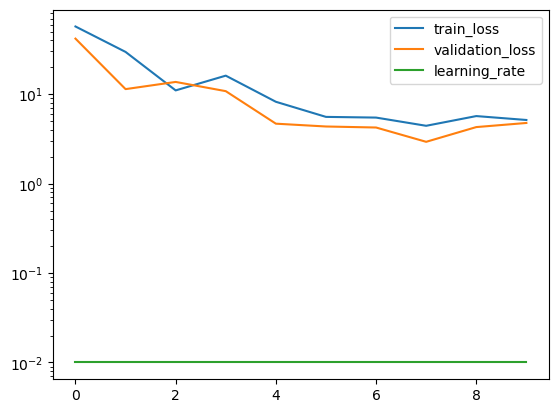

In [3]:
# qchem dataset (QM7X) and cosmosis model (FFNet)
# extract, filter, transform, load, model, metrics, display

model_param = {'in_channels': 23*23,
                'hidden': 2048, 
                'out_channels': 1, 
                'model_name': 'funnel'}

features = ['DIP','HLgap','atC6','atNUM','atPOL','atXYZ','hDIP','eAT',
            'eC','eDFTB+MBD','eEE','eH','eKIN','eKSE','eL','eMBD','eNE', 
            'eNN','ePBE0','ePBE0+MBD','eTS','eX','eXC','eXX','hCHG', 
            'hRAT','hVDIP','hVOL','mC6','mPOL','mTPOL','pbe0FOR', 
            'sMIT','sRMSD','totFOR','vDIP','vEQ','vIQ','vTQ','vdwFOR','vdwR',
            'coulomb','distance']

ds_param = {'train_param': {'input_dict': {'X': ['coulomb'],
                                           'y': ['eAT']},
                            'transforms': {'coulomb': [FlattenN(), Pad1d(23*23)]},
                            'selector': ['opt'],
                            'n': 1000, #non-random subset for testing
                             }}

metrics_param = {'report_interval': 100,
                 'log_plot': True,
                 'min_lr': .0013}  #early stopping

crit_param = {'reduction': 'sum'}

sample_param = {'set_seed': 88,
                'splits': (.7,.15),
                 #'subset': .2 #create random subset
                } 

sched_param = {'factor': .6,
               'patience': 5,
               'cooldown': 5,
               'min_lr': .00125}


opt_param = {'lr': 0.01}

l = Learn([QM7X], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_param=model_param, ds_param=ds_param, sample_param=sample_param,
          opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
          metrics_param=metrics_param,
          batch_size=128, epochs=10)

In [4]:
# qchem dataset (ANI1x) with PyG Data output
# extract, filter, transform, display

ds_param = {'train_param': {'input_dict': {'X': ['coulomb'],
                                           'y': ['wb97x_dz.energy']},
                            'transforms': {'coulomb': [FlattenN(), Pad1d((63*63))]},
                            'criterion': ['wb97x_dz.energy'],
                            'conformation': 'max',
                            'in_file': './data/ani1x/ani1x-release.h5',
                            'dict2data': True}}

ani1x = ANI1x(**ds_param['train_param'])
k = ani1x.ds_idx[0]
print(k)
ani1x[k]

molecules loaded:  1000
molecules loaded:  2000
molecules loaded:  3000
molecules loaded:  3114
CDataset created...
QDataset created...
C10H10


Data(y=[1], X=[3969])

molecules loaded:  1000
molecules loaded:  2000
molecules loaded:  3000
molecules loaded:  3114
CDataset created...
QDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...

...........................
learning time: 0:00:01.025570
epoch: 0, lr: 0.01
train loss: 457.241330315085, val loss: 272.0874285016741
last 5 targets: 
[-488.59094 -284.0237  -551.09576 -345.46924 -536.93677]
last 5 predictions: 
[-252.55856 -194.68886 -240.05179 -245.94324 -381.75403]

...........................
learning time: 0:00:09.130123
epoch: 10, lr: 0.01
train loss: 33.37232191422407, val loss: 33.349958419799805
last 5 targets: 
[-384.468   -727.51483 -509.34915 -681.5662  -744.225  ]
last 5 predictions: 
[-392.8709  -759.2792  -503.0849  -691.566   -758.63165]
test loss: 30.854946408952987

...........................
learning time: 0:00:16.542758
last 5 targets: 
[-667.136   -604.81476 -457.28925 -119.05935 -627.7167 ]
last 5 predictions: 
[-662.626   -594.46515 -449.2103  -154

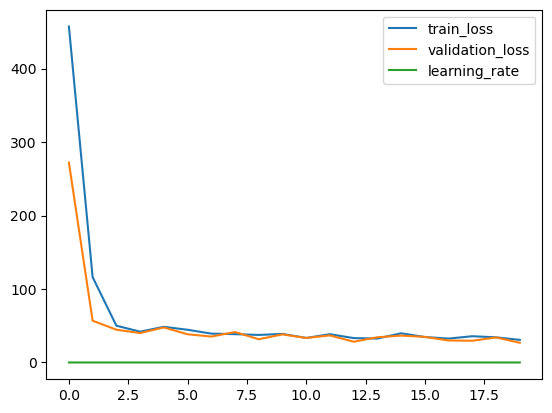

In [5]:
# qchem dataset (ANI1x) and comosis model (FFNet)
# extract, filter, transform, load, model, metrics, display

model_param = {'in_channels': 63*63, #length of the longest molecule in the dataset
                'hidden': 2000, 
                'out_channels': 1, 
                'model_name': 'funnel'
               }

ds_param = {'train_param': {'input_dict': {'X': ['coulomb'],
                                           'y': ['wb97x_dz.energy']},
                            'transforms': {'coulomb': [FlattenN(), Pad1d((63*63))]},
                            'criterion': ['wb97x_dz.energy'],
                            'conformation': 'max',
                            'in_file': './data/ani1x/ani1x-release.h5',
                            'dict2data': False}}

metrics_param = {'report_interval': 100,
                 'log_plot': True,
                 'min_lr': .0013}  #early stopping

crit_param = {'reduction': 'sum'}

sample_param = {'set_seed': 88,
                'splits': (.7,.15)}

sched_param = {'factor': .6,
               'patience': 5,
               'cooldown': 5,
               'min_lr': .00125}

opt_param = {'lr': 0.01}

l = Learn([ANI1x], FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_param=model_param, ds_param=ds_param, sample_param=sample_param,
          opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
          batch_size=64, epochs=20)